In [19]:
# --- 1. Bibliotekos ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import requests
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow versija: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow versija: 2.19.0


In [20]:
# --- 2. Duomenų gavimas iš Binance API (365 dienų, 15min intervalas) ---
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"

def get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=None, end_time=None):
    if end_time is None:
        end_time = datetime.now()
    if start_time is None:
        start_time = end_time - timedelta(days=365)
    start_ts = int(start_time.timestamp() * 1000)
    end_ts = int(end_time.timestamp() * 1000)
    all_klines = []
    current_start = start_ts
    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1000
        }
        try:
            response = requests.get(BINANCE_API_URL, params=params)
            response.raise_for_status()
            klines = response.json()
            if not klines:
                break
            all_klines.extend(klines)
            current_start = int(klines[-1][0]) + 1
            time.sleep(0.5)
        except Exception as e:
            print(f"Klaida gaunant duomenis: {str(e)}")
            time.sleep(2)
    if all_klines:
        columns = ['time', 'open', 'high', 'low', 'close', 'volume', 
                   'close_time', 'quote_asset_volume', 'number_of_trades',
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df = pd.DataFrame(all_klines, columns=columns)
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_columns] = df[numeric_columns].astype(float)
        print(f"Sėkmingai gauta {len(df)} įrašų")
        return df
    return None

# Naudojame cached duomenis, jei turime, kitu atveju gauname naujus
cached_data_path = os.path.join('..', '..', 'data', 'btc_data_1y_15m.csv')
os.makedirs(os.path.dirname(cached_data_path), exist_ok=True)

if os.path.exists(cached_data_path):
    print(f"Naudojami cached duomenys iš {cached_data_path}")
    df = pd.read_csv(cached_data_path)
    df['time'] = pd.to_datetime(df['time'])
else:
    end_time = datetime.now()
    start_time = end_time - timedelta(days=365)
    print(f"Gaunami duomenys nuo {start_time} iki {end_time}...")
    df = get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=start_time, end_time=end_time)
    if df is not None:
        # Išsaugome duomenis ateičiai
        df.to_csv(cached_data_path, index=False)
    else:
        raise Exception("Nepavyko gauti duomenų, tęsti negalima.")

print(f"Duomenų dydis: {df.shape}")
display(df.head())

Gaunami duomenys nuo 2024-05-21 16:53:06.682115 iki 2025-05-21 16:53:06.682115...
Sėkmingai gauta 35040 įrašų
Duomenų dydis: (35040, 12)


,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2024-05-21 14:00:00,70595.92,70847.77,70560.00,70777.91,584.15346,1716300899999,41307325.58872220,23464,307.29840000,21730326.65438200,0
1,2024-05-21 14:15:00,70777.91,70833.80,70329.82,70419.44,705.06014,1716301799999,49760773.05804990,26447,284.99746000,20110106.29804080,0
2,2024-05-21 14:30:00,70419.44,70927.48,70417.79,70456.81,611.94862,1716302699999,43230312.50984260,28584,317.29213000,22411098.83042320,0
3,2024-05-21 14:45:00,70456.82,70507.24,70187.76,70213.20,756.49794,1716303599999,53236935.18382860,50211,287.23001000,20213664.71805340,0
4,2024-05-21 15:00:00,70213.21,70342.68,70153.69,70247.83,669.15517,1716304499999,46997333.47917950,34871,285.00191000,20016561.92463740,0


In [21]:
# --- 3. Duomenų paruošimas ir normalizavimas ---
df = df.sort_values('time')
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scaler = MinMaxScaler()
df_original = df.copy()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Patikriname normalizuotus duomenis
print("Normalizuotų duomenų statistika:")
print(df_normalized[columns_to_normalize].describe())

# Išsaugome scaler'į vėlesniam naudojimui
import pickle
os.makedirs('../../models', exist_ok=True)
with open('../../models/transformer_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Normalizuotų duomenų statistika:
               open          high           low         close        volume
count  35040.000000  35040.000000  35040.000000  35040.000000  35040.000000
mean       0.504274      0.496868      0.514773      0.504292      0.031584
std        0.274743      0.274887      0.274528      0.274753      0.040543
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.242512      0.234315      0.253421      0.242504      0.010924
50%        0.547065      0.540466      0.556620      0.547083      0.019525
75%        0.777161      0.769569      0.787709      0.777164      0.036745
max        1.000000      1.000000      1.000000      1.000000      1.000000


In [22]:
# --- 4. Sliding window sekų kūrimas ---
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

sequence_length = 24  # Transformer dažnai veikia geriau su ilgesnėmis sekomis
target_column = 'close'
feature_columns = ['open', 'high', 'low', 'close', 'volume']
X, y = create_sequences(df_normalized, target_column, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Patikriname duomenų reikšmes ir formą
print(f"X tipas: {X.dtype}, y tipas: {y.dtype}")
print(f"X min/max: {X.min():.6f}/{X.max():.6f}, y min/max: {y.min():.6f}/{y.max():.6f}")

X shape: (35016, 24, 5), y shape: (35016,)
X tipas: float64, y tipas: float64
X min/max: 0.000000/1.000000, y min/max: 0.000000/1.000000


In [23]:
# --- 5. Duomenų padalijimas į mokymo ir testavimo rinkinius ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Patikrinimas, ar duomenys tinkamo formato
print(f"X_train min/max: {X_train.min():.6f}/{X_train.max():.6f}")
print(f"y_train min/max: {y_train.min():.6f}/{y_train.max():.6f}")

X_train shape: (28012, 24, 5), X_test shape: (7004, 24, 5)
y_train shape: (28012,), y_test shape: (7004,)
X_train min/max: 0.000000/1.000000
y_train min/max: 0.000000/1.000000


Positional encoding shape: (1, 24, 64)


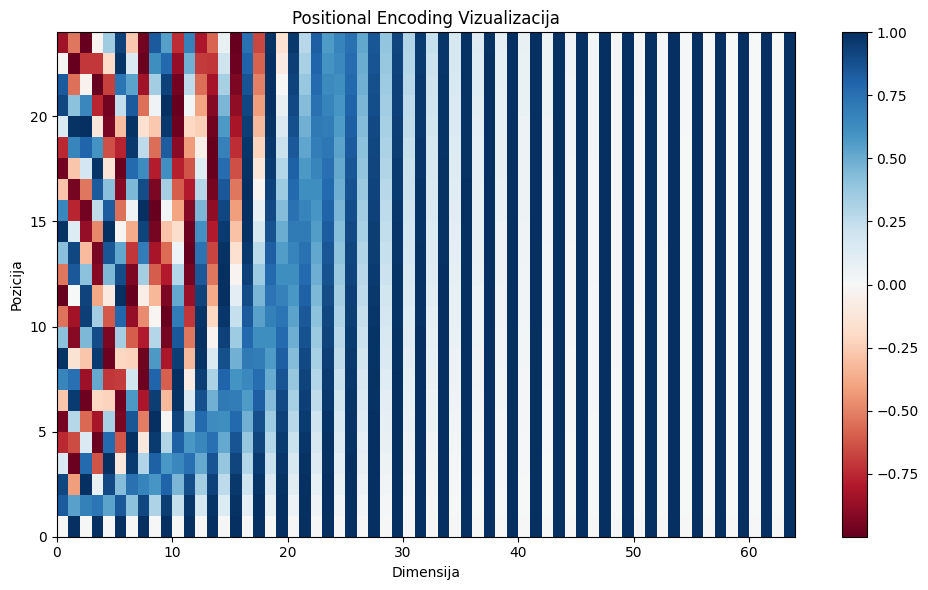

In [24]:
# --- 6. Positional Encoding implementacija ---
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Patikriname Positional Encoding
seq_len = sequence_length
d_model = 64
pos_encoding = get_positional_encoding(seq_len, d_model)
print(f"Positional encoding shape: {pos_encoding.shape}")

# Vizualizuojame Positional Encoding
plt.figure(figsize=(10, 6))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.title('Positional Encoding Vizualizacija')
plt.xlabel('Dimensija')
plt.ylabel('Pozicija')
plt.colorbar()
plt.tight_layout()
plt.show()

In [25]:
# --- 7. TimeSeriesTransformer modelio aprašymas ---
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, seq_len, num_features, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout
        
        # Embedding sluoksnis
        self.embedding = layers.Dense(d_model)
        
        # Positional encoding
        self.pos_encoding = get_positional_encoding(seq_len, d_model)
        
        # Multi-head attention
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed-forward network
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model),
        ])
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Output layers
        self.flatten = layers.Flatten()
        self.out = layers.Dense(1)

    def call(self, x, training=False):
        print_shapes = False  # Nustatykite į True, jei norite debuginti
        
        if print_shapes:
            print(f"Input x shape: {x.shape}")
        
        # Embedding
        x = self.embedding(x)
        if print_shapes:
            print(f"After embedding shape: {x.shape}")
        
        # Add positional encoding
        x = x + self.pos_encoding
        if print_shapes:
            print(f"After adding positional encoding shape: {x.shape}")
        
        # Multi-head attention
        attn_output = self.attention(x, x)
        if print_shapes:
            print(f"After attention shape: {attn_output.shape}")
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(x + attn_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.norm2(out1 + ffn_output)
        
        # Output
        out2 = self.flatten(out2)
        if print_shapes:
            print(f"After flatten shape: {out2.shape}")
        
        output = self.out(out2)
        if print_shapes:
            print(f"Final output shape: {output.shape}")
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "seq_len": self.seq_len,
            "num_features": self.num_features,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout_rate,
        })
        return config

In [26]:
# --- 8. Transformer modelio sukūrimas ---
d_model = 64
num_heads = 4
ff_dim = 128
dropout = 0.1

# Patikriname input shape
print(f"X_train shape: {X_train.shape}")
print(f"sequence_length: {sequence_length}, num_features: {X_train.shape[2]}")

# Tikriname, ar model.summary() veikia
transformer_model = TimeSeriesTransformer(
    seq_len=sequence_length,
    num_features=X_train.shape[2],
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout
)

# Tiesiogiai perduodame duomenis ir tikriname output
test_batch = X_train[:2]  # Pirmi 2 pavyzdžiai
print(f"Test batch shape: {test_batch.shape}")
with tf.GradientTape() as tape:
    output = transformer_model(test_batch, training=True)
    print(f"Output shape: {output.shape}")
    print(f"Output values: {output.numpy()}")

# Dabar jau turėtume galėti sukompiliuoti modelį
transformer_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

transformer_model.build(input_shape=(None, sequence_length, X_train.shape[2]))
transformer_model.summary()

X_train shape: (28012, 24, 5)
sequence_length: 24, num_features: 5
Test batch shape: (2, 24, 5)
Output shape: (2, 1)
Output values: [[-0.80027115]
 [-1.0323039 ]]


Model: "time_series_transformer_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (2, 24, 64)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_2          │ (2, 24, 64)            │        66,368 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (2, 24, 64)            │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (2, 24, 64)            │        16,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (2, 24, 64)            │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (2, 1536)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (2, 1)                 │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,121 (332.50 KB)

 Trainable params: 85,121 (332.50 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# --- 9. Modelio apmokymas ---
os.makedirs('../../models', exist_ok=True)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
checkpoint = callbacks.ModelCheckpoint(
    filepath='../../models/transformer_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Patikrinimas, ar duomenys teisingai paruošti
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

# Apmokymo paleidimas
print("Pradedamas modelio apmokymas...")
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("Modelio apmokymas baigtas.")

# Išsaugome modelį
transformer_model.save('../../models/transformer_model.h5')
print("Modelis išsaugotas į: ../../models/transformer_model.h5")

X_train.shape: (28012, 24, 5), y_train.shape: (28012,)
X_test.shape: (7004, 24, 5), y_test.shape: (7004,)
Pradedamas modelio apmokymas...
Epoch 1/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1553 - mae: 0.2307
Epoch 1: val_loss improved from inf to 0.00403, saving model to ../../models/transformer_model.h5


876/876 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.1549 - mae: 0.2303 - val_loss: 0.0040 - val_mae: 0.0624 - learning_rate: 0.0010
Epoch 2/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - mae: 0.0589
Epoch 2: val_loss improved from 0.00403 to 0.00040, saving model to ../../models/transformer_model.h5


876/876 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0055 - mae: 0.0589 - val_loss: 4.0052e-04 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 3/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - mae: 0.0434
Epoch 3: val_loss did not improve from 0.00040
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0030 - mae: 0.0434 - val_loss: 0.0033 - val_mae: 0.0565 - learning_rate: 0.0010
Epoch 4/50
875/876 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - mae: 0.0419
Epoch 4: val_loss did not improve from 0.00040
876/876 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0027 - mae: 0.0419 - val_loss: 6.1101e-04 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 5/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - mae: 0.0441
Epoch 5: val_loss did not improve from 0.00040
876/876 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0034 - mae: 0.0441 - val_loss: 0.0016 - val_mae: 0.0393 - learning_rate: 0.0010
Epoch 6/50
873/876 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - mae

876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 2.4888e-04 - mae: 0.0117 - val_loss: 4.8777e-05 - val_mae: 0.0050 - learning_rate: 2.0000e-04
Epoch 9/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2203e-04 - mae: 0.0086
Epoch 9: val_loss did not improve from 0.00005
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.2204e-04 - mae: 0.0086 - val_loss: 8.4497e-05 - val_mae: 0.0078 - learning_rate: 2.0000e-04
Epoch 10/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3164e-04 - mae: 0.0090
Epoch 10: val_loss did not improve from 0.00005
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.3164e-04 - mae: 0.0090 - val_loss: 1.1400e-04 - val_mae: 0.0095 - learning_rate: 2.0000e-04
Epoch 11/50
875/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3041e-04 - mae: 0.0089
Epoch 11: val_loss did not improve from 0.00005
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1.3046e-04 - mae: 0.0089 - val_loss: 5.3200e-05 - val_mae: 0.0058 - learning_rate: 2.0000e-04
Epoch 12/50
875/8


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001.
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.6403e-04 - mae: 0.0100 - val_loss: 3.4919e-05 - val_mae: 0.0046 - learning_rate: 2.0000e-04
Epoch 14/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7655e-05 - mae: 0.0063
Epoch 14: val_loss improved from 0.00003 to 0.00003, saving model to ../../models/transformer_model.h5


876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 6.7655e-05 - mae: 0.0063 - val_loss: 2.7482e-05 - val_mae: 0.0039 - learning_rate: 1.0000e-04
Epoch 15/50
873/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0078e-05 - mae: 0.0069
Epoch 15: val_loss did not improve from 0.00003
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 8.0096e-05 - mae: 0.0069 - val_loss: 3.6902e-05 - val_mae: 0.0047 - learning_rate: 1.0000e-04
Epoch 16/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4134e-05 - mae: 0.0067
Epoch 16: val_loss did not improve from 0.00003
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.4132e-05 - mae: 0.0067 - val_loss: 1.0226e-04 - val_mae: 0.0093 - learning_rate: 1.0000e-04
Epoch 17/50
872/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.6841e-05 - mae: 0.0068
Epoch 17: val_loss improved from 0.00003 to 0.00003, saving model to ../../models/transformer_model.h5


876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 7.6851e-05 - mae: 0.0068 - val_loss: 2.5842e-05 - val_mae: 0.0037 - learning_rate: 1.0000e-04
Epoch 18/50
873/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.6674e-05 - mae: 0.0068
Epoch 18: val_loss did not improve from 0.00003
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.6696e-05 - mae: 0.0068 - val_loss: 8.9299e-05 - val_mae: 0.0085 - learning_rate: 1.0000e-04
Epoch 19/50
873/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9572e-05 - mae: 0.0074
Epoch 19: val_loss did not improve from 0.00003
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 8.9564e-05 - mae: 0.0074 - val_loss: 3.0274e-05 - val_mae: 0.0043 - learning_rate: 1.0000e-04
Epoch 20/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2332e-05 - mae: 0.0061
Epoch 20: val_loss improved from 0.00003 to 0.00002, saving model to ../../models/transformer_model.h5


876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 6.2357e-05 - mae: 0.0061 - val_loss: 1.9163e-05 - val_mae: 0.0030 - learning_rate: 1.0000e-04
Epoch 21/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7500e-05 - mae: 0.0063
Epoch 21: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 6.7500e-05 - mae: 0.0063 - val_loss: 3.3695e-05 - val_mae: 0.0045 - learning_rate: 1.0000e-04
Epoch 22/50
875/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4102e-05 - mae: 0.0062
Epoch 22: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 6.4107e-05 - mae: 0.0062 - val_loss: 6.7732e-05 - val_mae: 0.0073 - learning_rate: 1.0000e-04
Epoch 23/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9307e-05 - mae: 0.0067
Epoch 23: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.9304e-05 - mae: 0.0067 - val_loss: 2.7486e-05 - val_mae: 0.0039 - learning_rate: 1.0000e-04
Epoch 24/50
874

876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 5.8425e-05 - mae: 0.0059 - val_loss: 1.8353e-05 - val_mae: 0.0030 - learning_rate: 1.0000e-04
Epoch 29/50
873/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8885e-05 - mae: 0.0063
Epoch 29: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 6.8871e-05 - mae: 0.0063 - val_loss: 2.0342e-05 - val_mae: 0.0033 - learning_rate: 1.0000e-04
Epoch 30/50
872/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9391e-05 - mae: 0.0059
Epoch 30: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 5.9386e-05 - mae: 0.0059 - val_loss: 9.5386e-05 - val_mae: 0.0089 - learning_rate: 1.0000e-04
Epoch 31/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4376e-05 - mae: 0.0066
Epoch 31: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.4365e-05 - mae: 0.0066 - val_loss: 1.9781e-05 - val_mae: 0.0032 - learning_rate: 1.0000e-04
Epoch 32/50
872

876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 6.7852e-05 - mae: 0.0063 - val_loss: 1.7883e-05 - val_mae: 0.0030 - learning_rate: 1.0000e-04
Epoch 37/50
873/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6330e-05 - mae: 0.0058
Epoch 37: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 5.6319e-05 - mae: 0.0058 - val_loss: 4.2526e-05 - val_mae: 0.0055 - learning_rate: 1.0000e-04
Epoch 38/50
873/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.0016e-05 - mae: 0.0064
Epoch 38: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 6.9970e-05 - mae: 0.0064 - val_loss: 2.5544e-05 - val_mae: 0.0039 - learning_rate: 1.0000e-04
Epoch 39/50
874/876 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5534e-05 - mae: 0.0052
Epoch 39: val_loss did not improve from 0.00002
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 4.5539e-05 - mae: 0.0052 - val_loss: 5.5680e-05 - val_mae: 0.0065 - learning_rate: 1.0000e-04
Epoch 40/50
874

Modelio apmokymas baigtas.
Modelis išsaugotas į: ../../models/transformer_model.h5


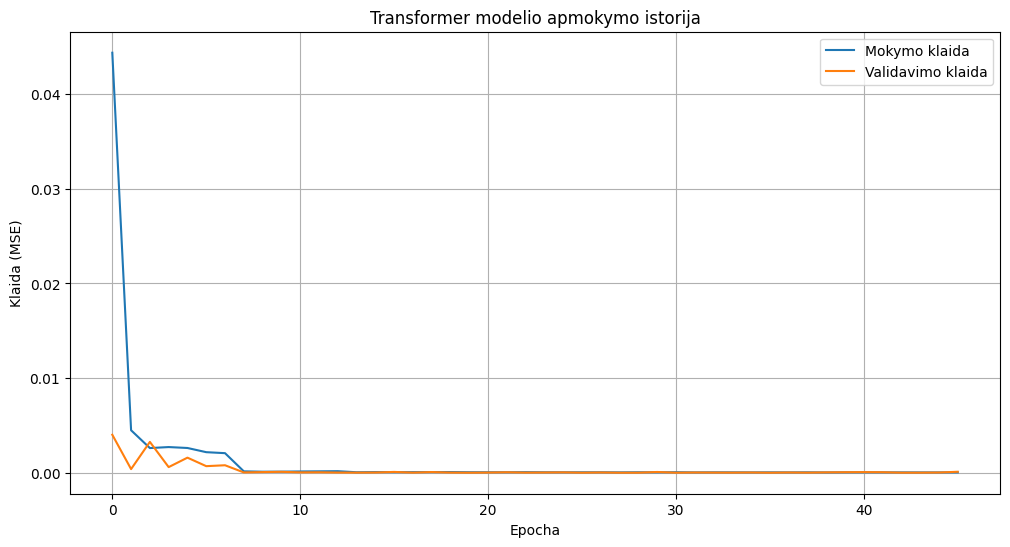

In [28]:
# --- 10. Apmokymo istorijos vizualizacija ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Mokymo klaida')
plt.plot(history.history['val_loss'], label='Validavimo klaida')
plt.title('Transformer modelio apmokymo istorija')
plt.xlabel('Epocha')
plt.ylabel('Klaida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

if 'lr' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Kitimas')
    plt.xlabel('Epocha')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

In [29]:
# --- 11. Prognozės ir atstatymas į originalią skalę ---
print("Generuojamos prognozės...")
y_pred = transformer_model.predict(X_test)
print(f"Prognozių forma: {y_pred.shape}")

def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_names=None):
    dummy = np.zeros((len(predictions), len(feature_names) if feature_names else 5))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

target_idx = feature_columns.index(target_column)
y_pred_original = inverse_transform_predictions(y_pred, scaler, target_idx, feature_columns)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx, feature_columns)

print(f"y_pred_original shape: {y_pred_original.shape}")
print(f"y_test_original shape: {y_test_original.shape}")

Generuojamos prognozės...
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Prognozių forma: (7004, 1)
y_pred_original shape: (7004,)
y_test_original shape: (7004,)


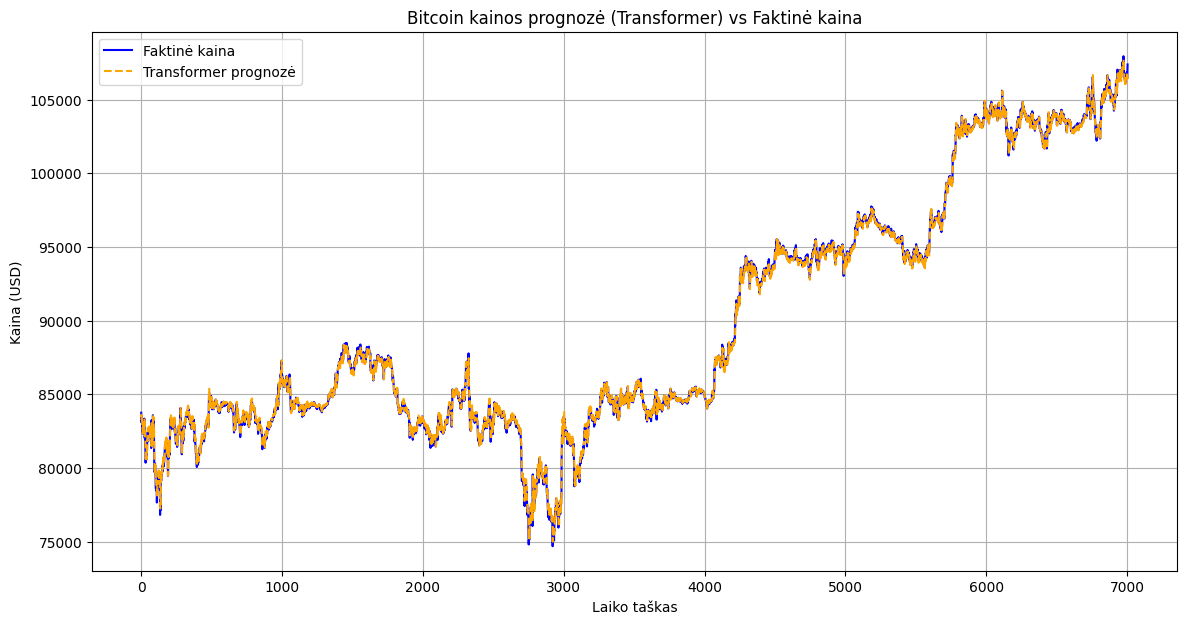

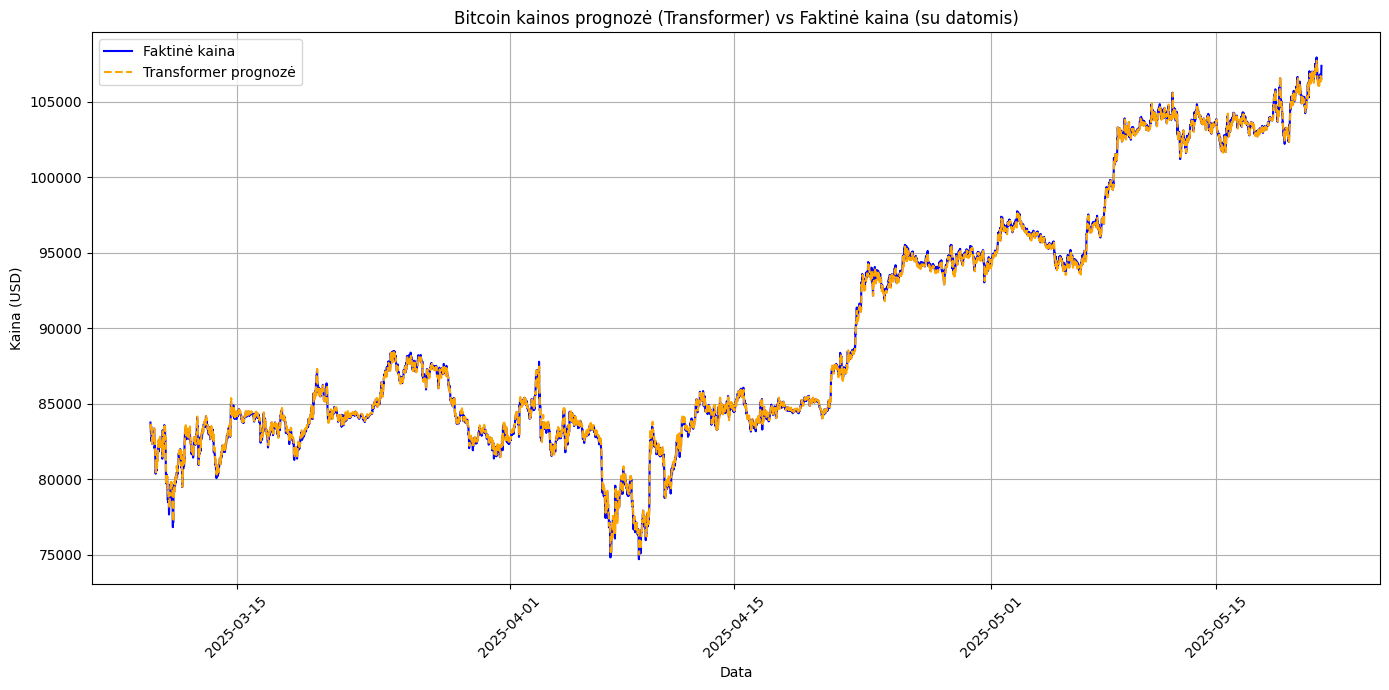

In [30]:
# --- 12. Prognozių vizualizacija ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Faktinė kaina', color='blue')
plt.plot(y_pred_original, label='Transformer prognozė', color='orange', linestyle='--')
plt.title('Bitcoin kainos prognozė (Transformer) vs Faktinė kaina')
plt.xlabel('Laiko taškas')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Su datomis
test_dates = df_original['time'].iloc[-len(y_test):].reset_index(drop=True)
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='blue')
plt.plot(test_dates, y_pred_original, label='Transformer prognozė', color='orange', linestyle='--')
plt.title('Bitcoin kainos prognozė (Transformer) vs Faktinė kaina (su datomis)')
plt.xlabel('Data')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# --- 13. Modelio įvertinimas ---
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Sukuriame DataFrame geresniam pavaizavimui
metrics_df = pd.DataFrame({
    'Metrika': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Reikšmė': [mse, rmse, mae, r2, mape]
})
display(metrics_df)

Mean Squared Error (MSE): 62764.02
Root Mean Squared Error (RMSE): 250.53
Mean Absolute Error (MAE): 175.09
R² Score: 0.9991
Mean Absolute Percentage Error (MAPE): 0.20%


,Metrika,Reikšmė
0,MSE,62764.018694
1,RMSE,250.527481
2,MAE,175.089187
3,R²,0.999072
4,MAPE (%),0.198173


In [32]:
# --- 14. Modelio informacijos išsaugojimas ---
import json

model_info = {
    'model_type': 'Transformer',
    'input_shape': [sequence_length, len(feature_columns)],
    'sequence_length': sequence_length,
    'target_column': target_column,
    'params': {
        'd_model': d_model,
        'num_heads': num_heads,
        'ff_dim': ff_dim,
        'dropout': dropout
    },
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'mape': float(mape)
    }
}

model_info_path = '../../models/transformer_model_info.json'
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Modelio informacija išsaugota: {model_info_path}")
print("Transformer modelio apmokymas ir įvertinimas baigtas!")

Modelio informacija išsaugota: ../../models/transformer_model_info.json
Transformer modelio apmokymas ir įvertinimas baigtas!
